In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bioframe
from hmmlearn import hmm
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Read 4C data and TetO coordinates

In [2]:
teto_coordinates = pd.read_csv('C17_TetO_locations_manual_TACL_domains.txt', sep = '\t')
teto_coordinates.head()

,chrom,start,end,teto_id,domain_small_start,domain_small_end,domain_large_start,domain_large_end
0,chr3,33400162,33400162,1,32943025,33896603,29979716,37412478
1,chr17,19456127,19456127,2,19355266,20333029,17348282,22822656
2,chr1,237830986,237830986,3,237543776,240050358,233321503,242063930
3,chr18,47931745,47931745,4,47083150,48559650,43557896,51704212
4,chr8,65550156,65550156,5,64245069,66639209,61012154,69728571


In [3]:
tacl_domains = pd.read_csv('TACL_domains_HMM.bed', sep = '\t', header = None)
tacl_domains.columns = ['chrom', 'start', 'end', 'teto_id']
tacl_domains.head()

,chrom,start,end,teto_id
0,chr3,32710370,34267172,1
1,chr17,19348155,21034668,2
2,chr1,237514789,239990427,3
3,chr18,46949582,48492721,4
4,chr8,64261002,66451818,5


In [4]:
vp_data_merged_1 = pd.read_csv('4C_data_degrons_domains_HMM.txt.gz', sep = '\t')
vp_data_merged_2 = pd.read_csv('4C_data_TACL_domains_HMM.txt.gz', sep = '\t')
vp_data_merged = vp_data_merged_1.merge(vp_data_merged_2, on = ['chrom', 'start', 'end', 'mid', 'teto_id'], how = 'inner')
vp_data_merged

,chrom,start,end,ctcf_unt,ctcf_iaa3h,ctcf_dox3h,pds5a_unt,pds5a_iaa3h,pds5a_dox3h,stag2_unt,stag2_iaa1h,stag2_dox3h,wapl_unt,wapl_iaa3h,wapl_dox3h,teto_id,mid,norm_MAU2,norm_mCherry
0,chr3,23400574,23400660,2.518384e+00,6.204816e+00,8.974953e-01,2.501276e+00,6.643694,1.476507e+00,3.177720,3.433877e+00,7.030495e+00,6.204413,0.610881,4.765484,1,23400617.0,3.386276,11.694652
1,chr3,23400871,23401212,2.324662e+00,5.727522e+00,3.313829e+00,4.617740e+00,8.858259,1.362930e+00,2.933280,3.169733e+00,8.112109e+00,5.727151,0.563890,4.398908,1,23401041.5,3.362760,13.334756
2,chr3,23402320,23402344,2.158615e+00,5.318413e+00,3.077127e+00,4.287901e+00,8.225526,1.265578e+00,2.723760,2.943323e+00,7.532673e+00,5.318068,0.523612,4.084700,1,23402332.0,3.104086,12.309005
3,chr3,23402464,23402607,2.014707e+00,4.963853e+00,2.871985e+00,4.002041e+00,7.677158,1.181206e+00,2.542176,2.747102e+00,7.030495e+00,4.963530,0.488705,3.812387,1,23402535.5,2.882366,11.653904
4,chr3,23402604,23402743,1.888788e+00,4.653612e+00,2.692486e+00,3.751913e+00,7.197335,1.107380e+00,3.574935,2.575408e+00,6.591089e+00,4.653310,0.458161,3.574113,1,23402673.5,2.690208,10.876977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653068,chr5,44367977,44368490,-8.147557e-14,-8.644937e-15,1.143974e-13,1.615300e-13,4.673279,-1.440033e-13,0.985450,1.610564e-13,-9.426534e-14,19.498879,24.420024,0.000000,27,44368233.5,2.660242,11.028398
653069,chr5,44368626,44368772,-8.729525e-14,-9.262432e-15,1.225686e-13,1.730679e-13,5.007085,-1.542893e-13,1.055839,1.725604e-13,-1.009986e-13,20.891656,26.164312,0.000000,27,44368699.0,2.850259,11.816141
653070,chr5,44370418,44370843,-9.401027e-14,-9.974927e-15,1.319970e-13,1.863808e-13,5.392245,-1.661577e-13,1.137057,1.858343e-13,-1.087677e-13,22.498706,28.176951,0.000000,27,44370630.5,3.069510,12.725075
653071,chr5,44372335,44372650,-1.018445e-13,-1.080617e-14,1.429967e-13,2.019126e-13,5.841599,-1.800042e-13,1.231812,2.013204e-13,-1.178317e-13,24.373599,30.525031,0.000000,27,44372492.5,3.325303,13.785498


## Define HMM model parameters and filter parameters

In [5]:
# Set HMM parameters
cutoff = 25
print('Delta signal cutoff:', cutoff)

prob_tacl_domain = 0.60
prob_no_domain = 0.02
emission_matrix = np.array([[prob_tacl_domain, 1-prob_tacl_domain],
                            [prob_no_domain, 1-prob_no_domain]])
print('\nEmission matrix:\n', emission_matrix)

transition = 0.000001
transition_matrix = np.array([[1-transition, transition],
                              [transition, 1-transition]])
print('\nTransition matrix:\n', transition_matrix)

consecutive_threshold = 20
print('\nConsecutive HMM calls threshold:', consecutive_threshold)

merge_distance_restriction_fragments = 100000
number_restriction_fragments = 40
merge_distance_hmm_domains = 2500000
print('\nMerge distance clustering restriction fragments :', merge_distance_restriction_fragments)
print('Minimal number of restriction fragments to keep clusters:', number_restriction_fragments)
print('Merge distance calling domains:', merge_distance_hmm_domains)

Delta signal cutoff: 25

Emission matrix:
 [[0.6  0.4 ]
 [0.02 0.98]]

Transition matrix:
 [[9.99999e-01 1.00000e-06]
 [1.00000e-06 9.99999e-01]]

Consecutive HMM calls threshold: 20

Merge distance clustering restriction fragments : 100000
Minimal number of restriction fragments to keep clusters: 40
Merge distance calling domains: 2500000


In [6]:
# Define HMM model for calling TACL domains
tacl_domains_model = hmm.CategoricalHMM(n_components = 2, random_state = 99, init_params = '')

# Initialise with estimated parameters
tacl_domains_model.transmat_ = transition_matrix
tacl_domains_model.emissionprob_ = emission_matrix
tacl_domains_model.startprob_ = np.array([1.0, 0.0])
tacl_domains_model

CategoricalHMM(init_params='', n_components=2, random_state=99)

## Call HMM states for each cell line

In [7]:
# Call domain states for all viewpoints
def get_binary_observations_relative(condition1, condition2, viewpoint_id, cutoff):
    observations = vp_data_merged[vp_data_merged['teto_id'] == viewpoint_id]
    deltas = observations[condition1] - observations[condition2]
    binary_deltas = [[1] if d > cutoff else [0] for d in deltas]
    return(binary_deltas)

def calculate_hmm_states(condition1, condition2, cutoff, failed_viewpoints = []):
    hmm_states_tacl_domains = []
    for viewpoint_id_hmm in range(1, 28):
        binary_signal_difference = get_binary_observations_relative(condition1, condition2, viewpoint_id_hmm, cutoff)
        if viewpoint_id_hmm in failed_viewpoints:
            hmm_states_tacl_domains = hmm_states_tacl_domains + list([np.nan]*len(binary_signal_difference))
        else:
            tacl_domains_model.fit(binary_signal_difference)
            hmm_results = tacl_domains_model.predict(binary_signal_difference)
            hmm_states_tacl_domains = hmm_states_tacl_domains + list(hmm_results)
    return(hmm_states_tacl_domains)

# Keep restriction fragments within consecutive HMM state calls
def calculate_intervals_from_range(list_range):
    list_range = list(list_range)
    intervals = []
    for idx, item in enumerate(list_range):
        if not idx or item-1 != intervals[-1][-1]:
            intervals.append([item])
        else:
            intervals[-1].append(item)
    return(intervals)

def calculate_confident_hmm_states(hmm_data, hmm_state_calls):
    hmm_state_intervals = calculate_intervals_from_range(hmm_data[hmm_data[hmm_state_calls] == 1].index)
    hmm_state_intervals_confident = [x for x in hmm_state_intervals if len(x) >= consecutive_threshold]
    hmm_state_intervals_confident = [item for items in hmm_state_intervals_confident for item in items]
    hmm_state_intervals_confident = np.unique(hmm_state_intervals_confident)
    hmm_states_tacl_domains_confident = [1 if x in hmm_state_intervals_confident else 0 for x in np.arange(len(hmm_data))]
    return(hmm_states_tacl_domains_confident)

In [8]:
vp_data_merged['hmm_state_stag2_iaa'] = calculate_hmm_states('stag2_unt', 'stag2_iaa1h', cutoff)
vp_data_merged

,chrom,start,end,ctcf_unt,ctcf_iaa3h,ctcf_dox3h,pds5a_unt,pds5a_iaa3h,pds5a_dox3h,stag2_unt,stag2_iaa1h,stag2_dox3h,wapl_unt,wapl_iaa3h,wapl_dox3h,teto_id,mid,norm_MAU2,norm_mCherry,hmm_state_stag2_iaa
0,chr3,23400574,23400660,2.518384e+00,6.204816e+00,8.974953e-01,2.501276e+00,6.643694,1.476507e+00,3.177720,3.433877e+00,7.030495e+00,6.204413,0.610881,4.765484,1,23400617.0,3.386276,11.694652,0
1,chr3,23400871,23401212,2.324662e+00,5.727522e+00,3.313829e+00,4.617740e+00,8.858259,1.362930e+00,2.933280,3.169733e+00,8.112109e+00,5.727151,0.563890,4.398908,1,23401041.5,3.362760,13.334756,0
2,chr3,23402320,23402344,2.158615e+00,5.318413e+00,3.077127e+00,4.287901e+00,8.225526,1.265578e+00,2.723760,2.943323e+00,7.532673e+00,5.318068,0.523612,4.084700,1,23402332.0,3.104086,12.309005,0
3,chr3,23402464,23402607,2.014707e+00,4.963853e+00,2.871985e+00,4.002041e+00,7.677158,1.181206e+00,2.542176,2.747102e+00,7.030495e+00,4.963530,0.488705,3.812387,1,23402535.5,2.882366,11.653904,0
4,chr3,23402604,23402743,1.888788e+00,4.653612e+00,2.692486e+00,3.751913e+00,7.197335,1.107380e+00,3.574935,2.575408e+00,6.591089e+00,4.653310,0.458161,3.574113,1,23402673.5,2.690208,10.876977,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653068,chr5,44367977,44368490,-8.147557e-14,-8.644937e-15,1.143974e-13,1.615300e-13,4.673279,-1.440033e-13,0.985450,1.610564e-13,-9.426534e-14,19.498879,24.420024,0.000000,27,44368233.5,2.660242,11.028398,0
653069,chr5,44368626,44368772,-8.729525e-14,-9.262432e-15,1.225686e-13,1.730679e-13,5.007085,-1.542893e-13,1.055839,1.725604e-13,-1.009986e-13,20.891656,26.164312,0.000000,27,44368699.0,2.850259,11.816141,0
653070,chr5,44370418,44370843,-9.401027e-14,-9.974927e-15,1.319970e-13,1.863808e-13,5.392245,-1.661577e-13,1.137057,1.858343e-13,-1.087677e-13,22.498706,28.176951,0.000000,27,44370630.5,3.069510,12.725075,0
653071,chr5,44372335,44372650,-1.018445e-13,-1.080617e-14,1.429967e-13,2.019126e-13,5.841599,-1.800042e-13,1.231812,2.013204e-13,-1.178317e-13,24.373599,30.525031,0.000000,27,44372492.5,3.325303,13.785498,0


In [9]:
vp_data_merged['hmm_state_stag2_confident_iaa'] = calculate_confident_hmm_states(vp_data_merged, 'hmm_state_stag2_iaa')
vp_data_merged

,chrom,start,end,ctcf_unt,ctcf_iaa3h,ctcf_dox3h,pds5a_unt,pds5a_iaa3h,pds5a_dox3h,stag2_unt,...,stag2_dox3h,wapl_unt,wapl_iaa3h,wapl_dox3h,teto_id,mid,norm_MAU2,norm_mCherry,hmm_state_stag2_iaa,hmm_state_stag2_confident_iaa
0,chr3,23400574,23400660,2.518384e+00,6.204816e+00,8.974953e-01,2.501276e+00,6.643694,1.476507e+00,3.177720,...,7.030495e+00,6.204413,0.610881,4.765484,1,23400617.0,3.386276,11.694652,0,0
1,chr3,23400871,23401212,2.324662e+00,5.727522e+00,3.313829e+00,4.617740e+00,8.858259,1.362930e+00,2.933280,...,8.112109e+00,5.727151,0.563890,4.398908,1,23401041.5,3.362760,13.334756,0,0
2,chr3,23402320,23402344,2.158615e+00,5.318413e+00,3.077127e+00,4.287901e+00,8.225526,1.265578e+00,2.723760,...,7.532673e+00,5.318068,0.523612,4.084700,1,23402332.0,3.104086,12.309005,0,0
3,chr3,23402464,23402607,2.014707e+00,4.963853e+00,2.871985e+00,4.002041e+00,7.677158,1.181206e+00,2.542176,...,7.030495e+00,4.963530,0.488705,3.812387,1,23402535.5,2.882366,11.653904,0,0
4,chr3,23402604,23402743,1.888788e+00,4.653612e+00,2.692486e+00,3.751913e+00,7.197335,1.107380e+00,3.574935,...,6.591089e+00,4.653310,0.458161,3.574113,1,23402673.5,2.690208,10.876977,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653068,chr5,44367977,44368490,-8.147557e-14,-8.644937e-15,1.143974e-13,1.615300e-13,4.673279,-1.440033e-13,0.985450,...,-9.426534e-14,19.498879,24.420024,0.000000,27,44368233.5,2.660242,11.028398,0,0
653069,chr5,44368626,44368772,-8.729525e-14,-9.262432e-15,1.225686e-13,1.730679e-13,5.007085,-1.542893e-13,1.055839,...,-1.009986e-13,20.891656,26.164312,0.000000,27,44368699.0,2.850259,11.816141,0,0
653070,chr5,44370418,44370843,-9.401027e-14,-9.974927e-15,1.319970e-13,1.863808e-13,5.392245,-1.661577e-13,1.137057,...,-1.087677e-13,22.498706,28.176951,0.000000,27,44370630.5,3.069510,12.725075,0,0
653071,chr5,44372335,44372650,-1.018445e-13,-1.080617e-14,1.429967e-13,2.019126e-13,5.841599,-1.800042e-13,1.231812,...,-1.178317e-13,24.373599,30.525031,0.000000,27,44372492.5,3.325303,13.785498,0,0


## Define TACL domains

In [10]:
# Define TACL domains by stitching together consecutive regions with the same state
def find_tacl_domains(hmm_data, hmm_state_confident_calls, teto_coordinates, failed_viewpoints = []):
    tacl_domain_start, tacl_domain_end = [], []
    for viewpoint_id_hmm in range(1, 28):
        if viewpoint_id_hmm in failed_viewpoints:
            tacl_domain_start.append(np.nan)
            tacl_domain_end.append(np.nan)
        else:
            vp_hmm_results = hmm_data[hmm_data['teto_id'] == viewpoint_id_hmm]

            # Merge restriction fragments from TACL domain state within 100kb from each other
            draft_tacl_domain_small = bioframe.merge(vp_hmm_results[vp_hmm_results[hmm_state_confident_calls] == 1], min_dist = 200000)
            # Retain merged regions with at least 40 restriction fragments and further merge them within 2.5Mb distance
            draft_tacl_domain_large = bioframe.merge(draft_tacl_domain_small[draft_tacl_domain_small['n_intervals'] >= 40], min_dist = 2500000)

            # Overlap with TetO coordinates to avoid confusion when two platforms are close to each other
            called_tacl_domain = bioframe.overlap(draft_tacl_domain_large, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm]).dropna()
            # If TetO is outside of called TACL domain, find nearest domains on both sides and stitch them to include TetO
            if len(called_tacl_domain) == 0:
                closest_small_tacl_domains = bioframe.closest(draft_tacl_domain_small, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm], suffixes=('', '_teto'))
                closest_small_tacl_domains['abs_distance'] = (closest_small_tacl_domains['start'] + closest_small_tacl_domains['end'])/2 - closest_small_tacl_domains['start_teto']
                closest_right = closest_small_tacl_domains[closest_small_tacl_domains['abs_distance']>0].sort_values('distance').values[0][:4]
                closest_left = closest_small_tacl_domains[closest_small_tacl_domains['abs_distance']<0].sort_values('distance').values[0][:4]

                draft_tacl_domain_large_extended = (pd.DataFrame(list(draft_tacl_domain_large.values) + [list(closest_right), list(closest_left)]))
                draft_tacl_domain_large_extended.columns = ['chrom', 'start', 'end', 'n_intervals']
                draft_tacl_domain_large_extended = bioframe.merge(draft_tacl_domain_large_extended, min_dist = 2500000)
                called_tacl_domain = bioframe.overlap(draft_tacl_domain_large_extended, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm]).dropna()
            else:
                pass
            tacl_domain_start.append(called_tacl_domain.values[0][1])
            tacl_domain_end.append(called_tacl_domain.values[0][2])
    return([tacl_domain_start, tacl_domain_end])

In [11]:
tacl_domains_stag2_iaa = find_tacl_domains(vp_data_merged, 'hmm_state_stag2_confident_iaa', teto_coordinates)

In [12]:
tacl_domains['tacl_domain_stag2_iaa_start'] = tacl_domains_stag2_iaa[0]
tacl_domains['tacl_domain_stag2_iaa_end'] = tacl_domains_stag2_iaa[1]
tacl_domains

,chrom,start,end,teto_id,tacl_domain_stag2_iaa_start,tacl_domain_stag2_iaa_end
0,chr3,32710370,34267172,1,33011755,33868448
1,chr17,19348155,21034668,2,19269121,19990041
2,chr1,237514789,239990427,3,237379912,238896156
3,chr18,46949582,48492721,4,47094792,48483374
4,chr8,64261002,66451818,5,64509358,66183060
5,chrX,131792264,133688381,6,131825018,132981734
6,chr15,56391142,58292274,7,56716959,58189251
7,chr18,55225594,57174399,8,55575800,56870876
8,chr13,61946766,65660533,9,61874423,64105107
9,chr3,52839308,56309637,10,52848558,54784593


In [13]:
tacl_domains.to_csv('STAG2_lost_domains.txt', sep = '\t', header = 1, index = 0)

### Plot TACL domains

In [14]:
def plot_tacl_domains(viewpoint_data, viewpoint_id, cell_line, condition1, condition2, condition3, teto_coordinates, tacl_domains, flanking_region):
    plt.figure(figsize = (18, 3))
    plt.title(cell_line.upper() + ', TetO #' + str(viewpoint_id) + ', ' + ':'.join([str(x) for x in teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id].values[0][:2]]))
    
    # Plot 4C profiles
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     0,
                     [min(x) for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][[condition1, condition2]].values],
                     color = '#CCCCCC')
    
    mask_index = viewpoint_data[(viewpoint_data['teto_id'] == viewpoint_id) & (viewpoint_data[condition1]-viewpoint_data[condition2]>0)].index
    mask_bool = [1 if x in mask_index else 0 for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id].index]
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition1],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition2],
                     where = mask_bool, color = 'C1', label = condition1)
    
    mask_index = vp_data_merged[(vp_data_merged['teto_id'] == viewpoint_id) & (vp_data_merged[condition1]-vp_data_merged[condition2]<0)].index
    mask_bool = [1 if x in mask_index else 0 for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id].index]
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition1],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition2],
                     where = mask_bool, color = 'C2', label = condition2)

    # Plot TACL domains in degron condition
    plt.fill_betweenx(np.arange(1000), 
                      tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_stag2_iaa_start'].values[0], 
                      tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_stag2_iaa_end'].values[0],
                      color = 'orange', alpha = 0.15, zorder = 3, label = 'Lost domains, STAG2')
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_stag2_iaa_start'].values[0], 
                color = 'orange', alpha = 0.5, zorder = 3, lw = 2)
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_stag2_iaa_end'].values[0], 
                color = 'orange', alpha = 0.5, zorder = 3, lw = 2)
    
    # Plot TACL domains in TACL-ON condition
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id]['start'].values[0],
                color = 'blue', alpha = 1, zorder = 3, label = 'Original TACL domain')
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id]['end'].values[0], 
                color = 'blue', alpha = 1, zorder = 3)
    
    # Plot TetO integration
    plt.axvline(teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id]['start'].values[0], color = 'k')
    
    plt.xlim((tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'start'].values[0]-flanking_region,
              tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'end'].values[0]+flanking_region))
    plt.ylim((0, 1000))
    plt.legend()

    plt.show()

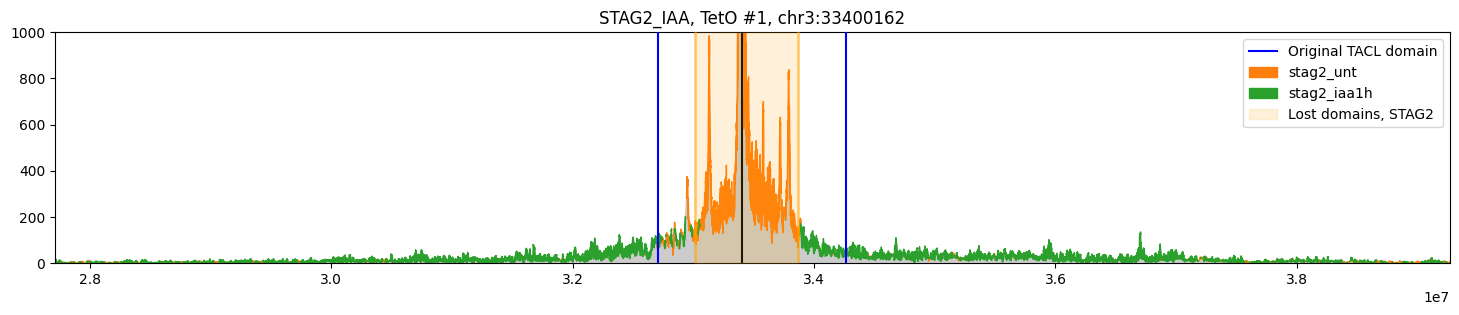

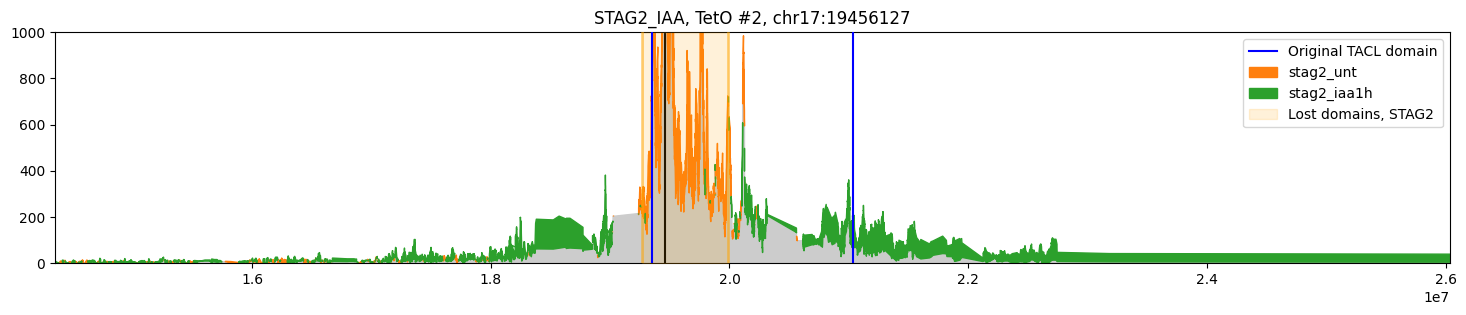

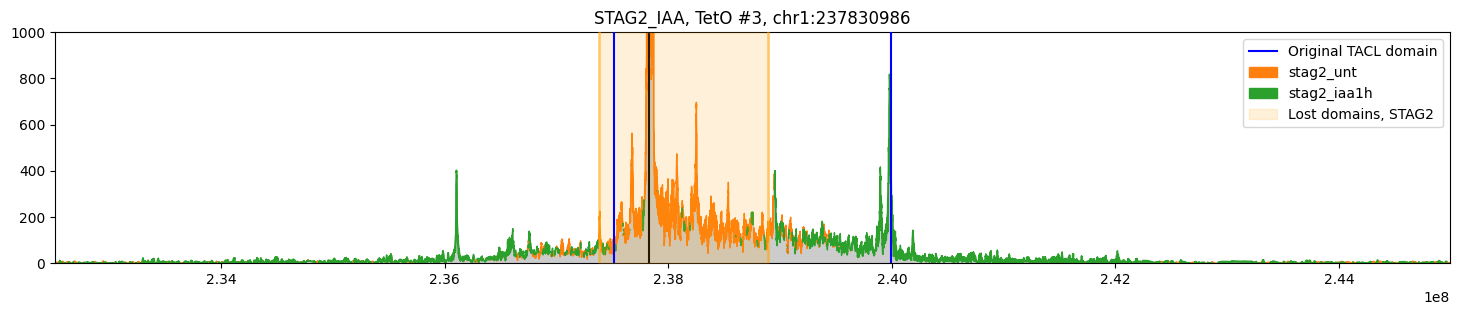

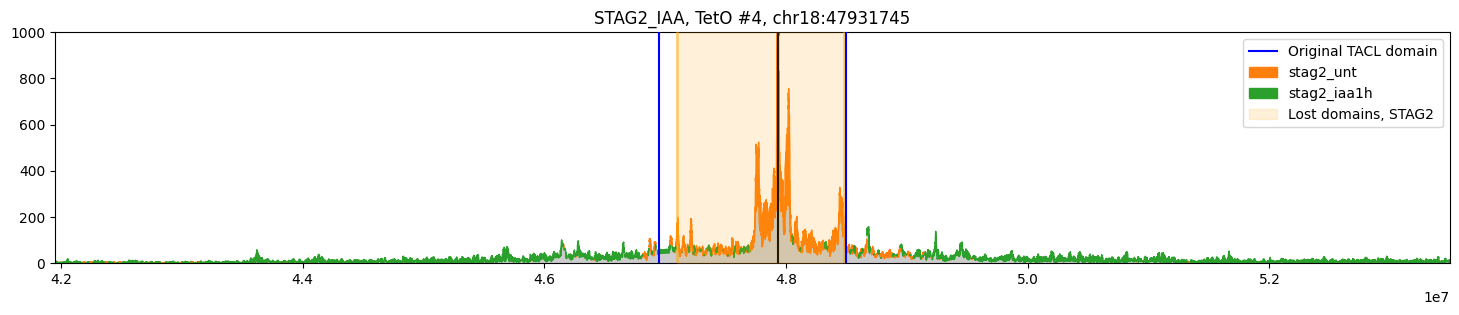

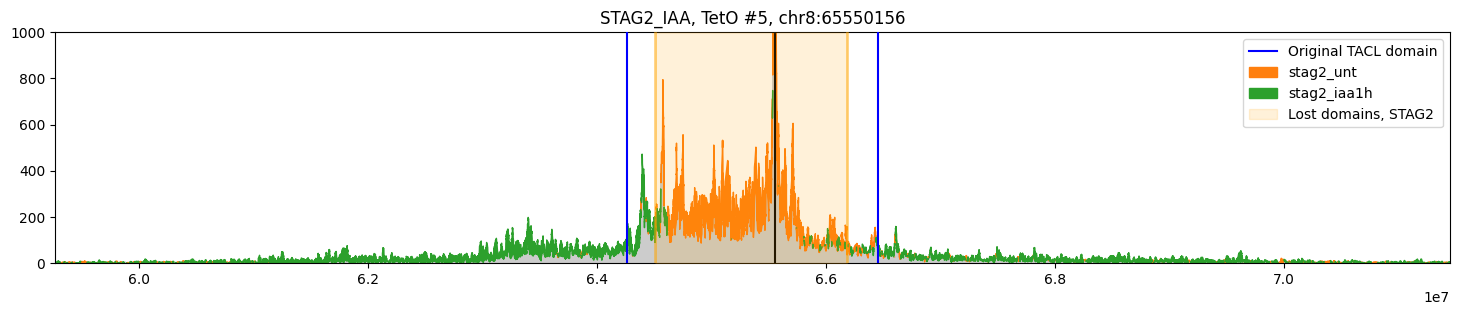

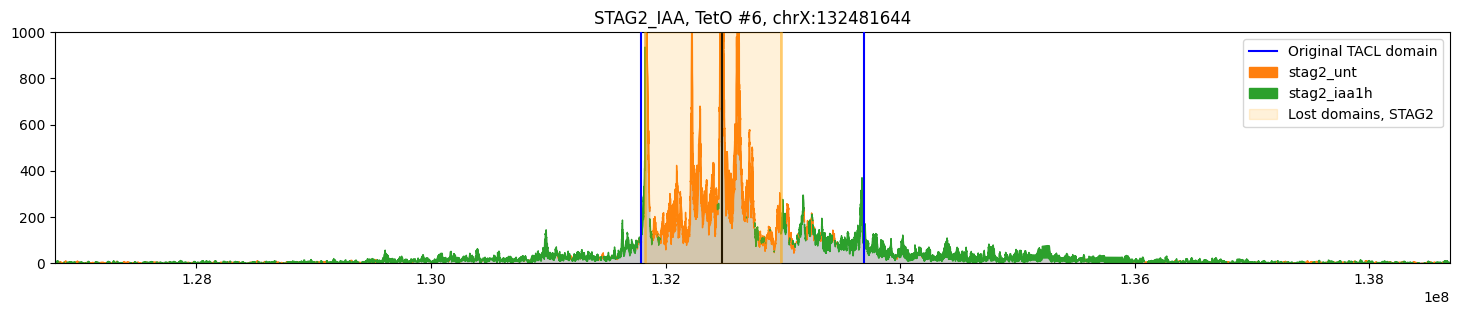

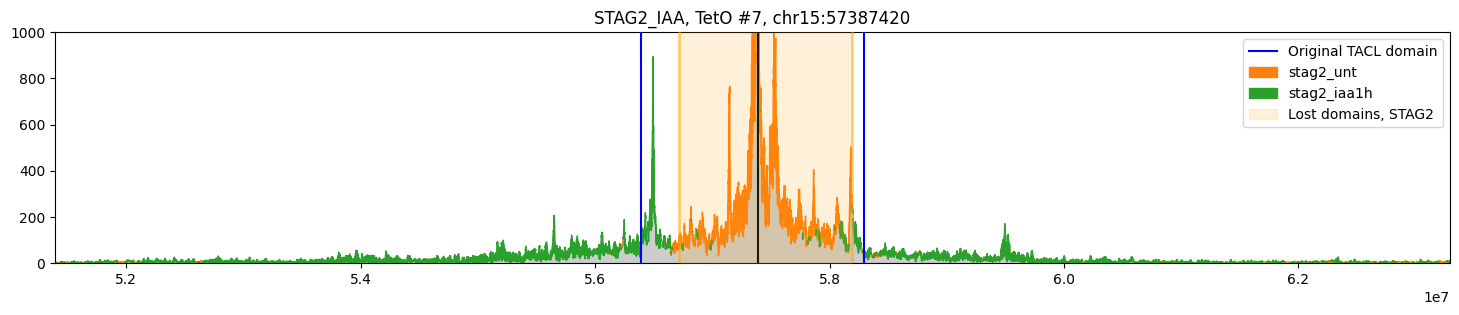

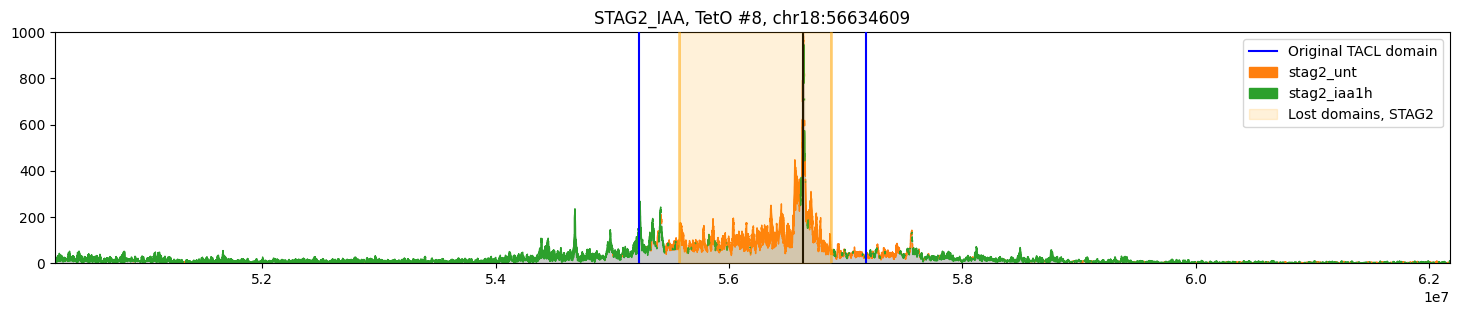

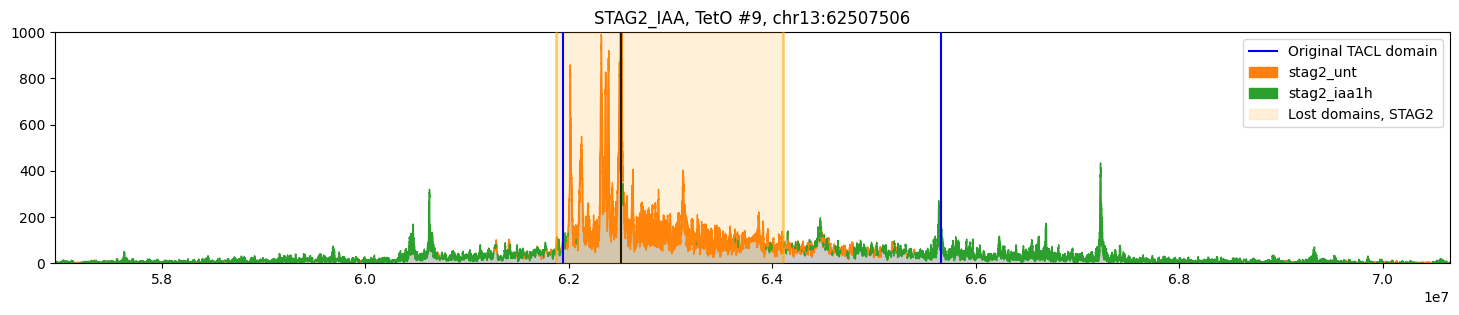

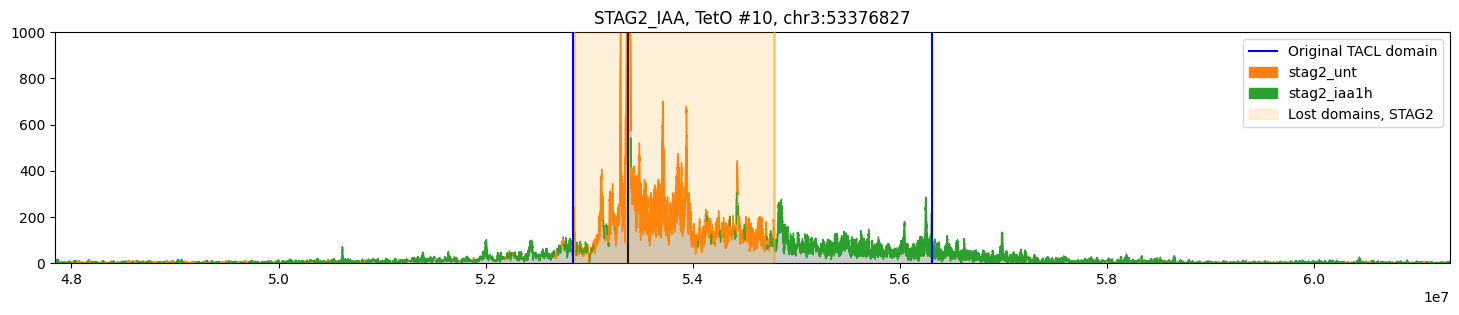

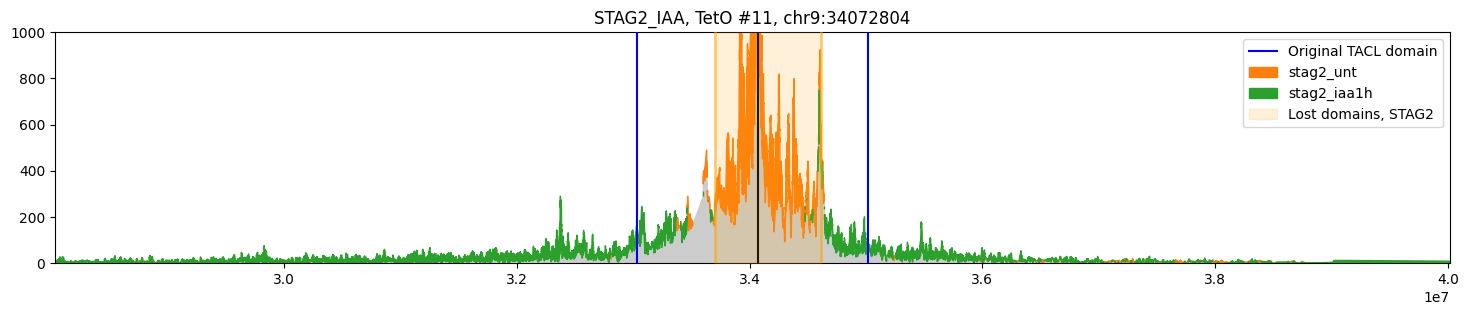

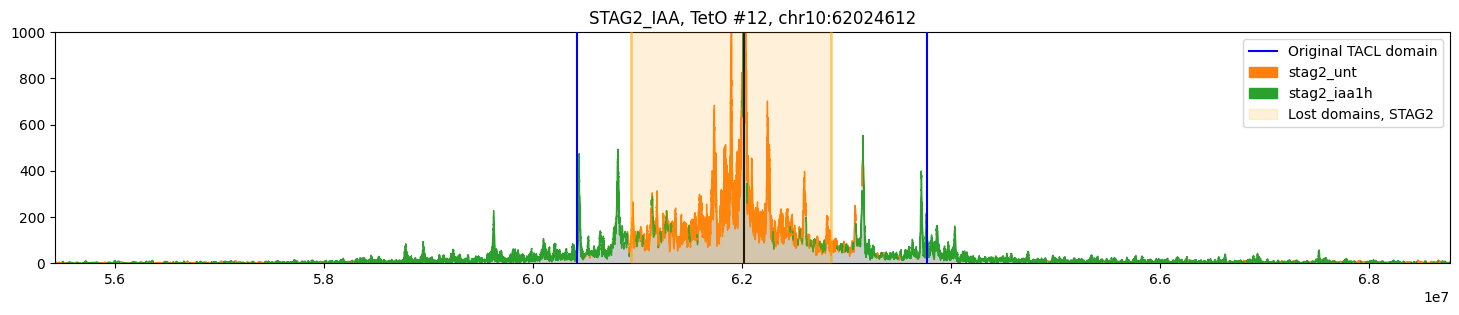

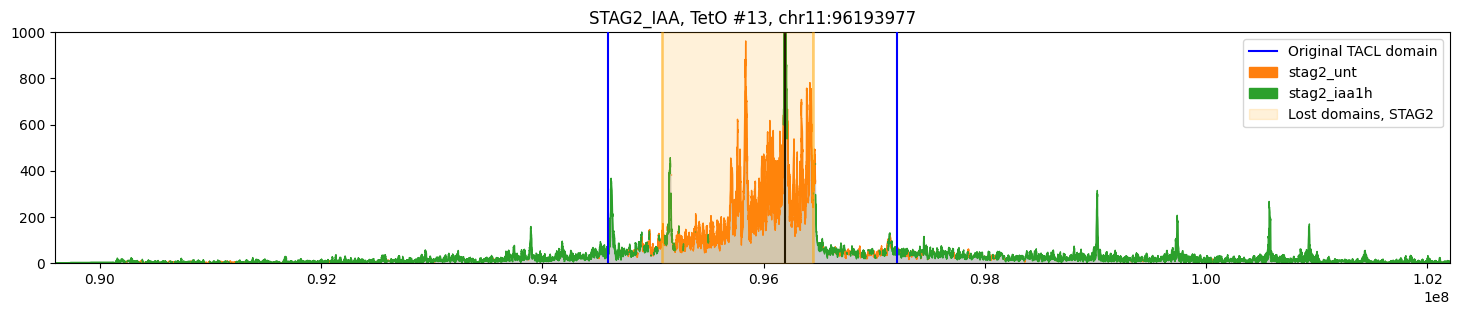

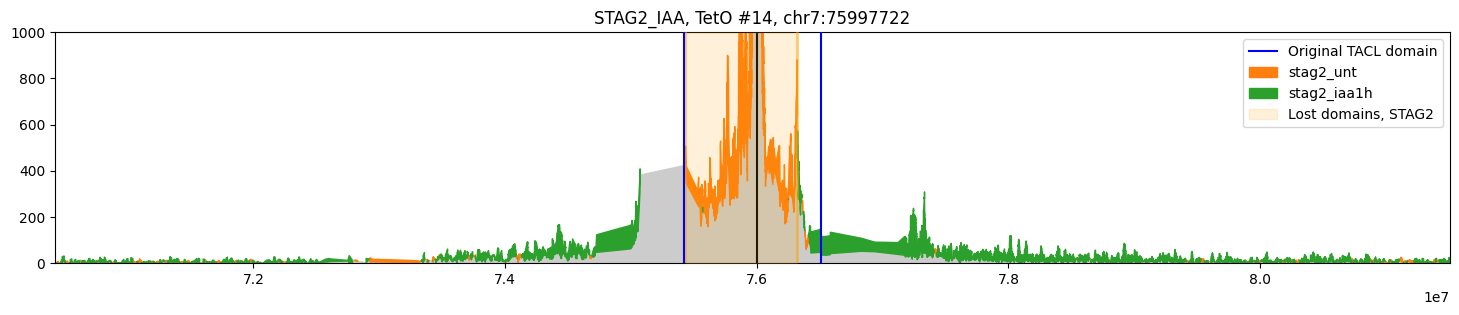

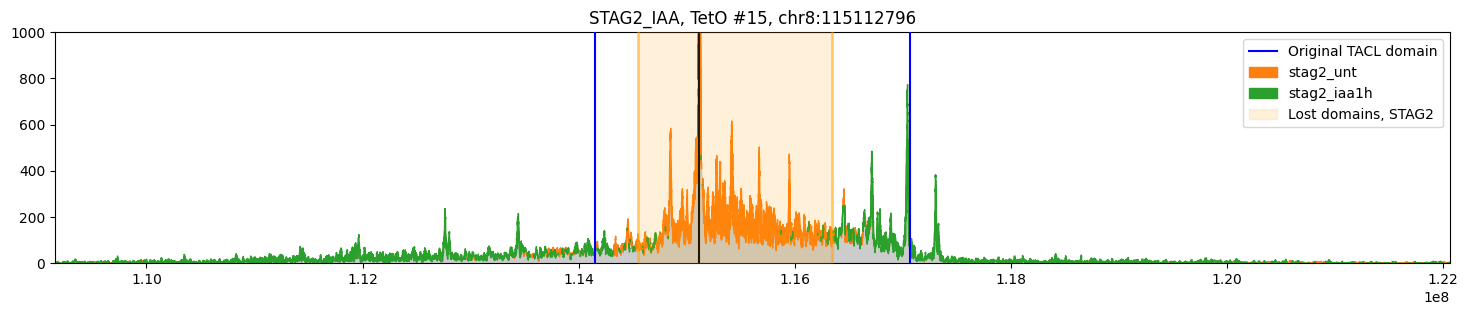

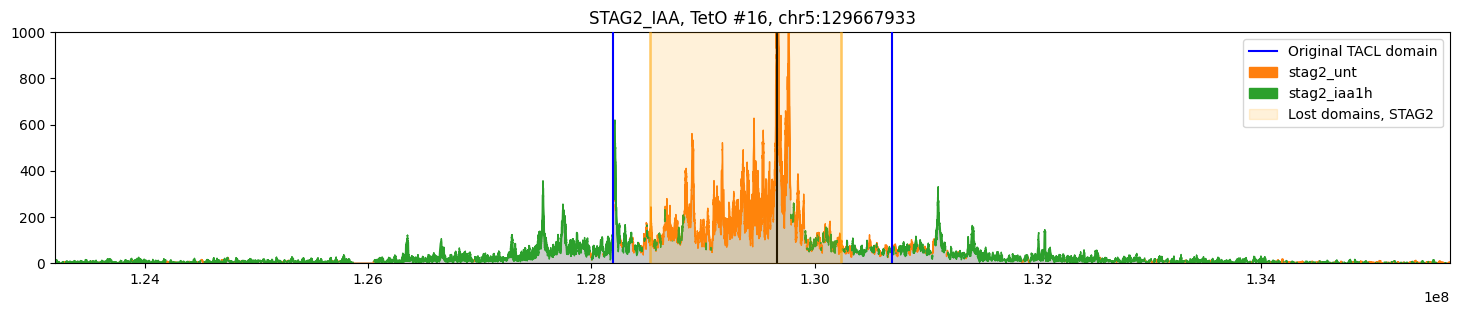

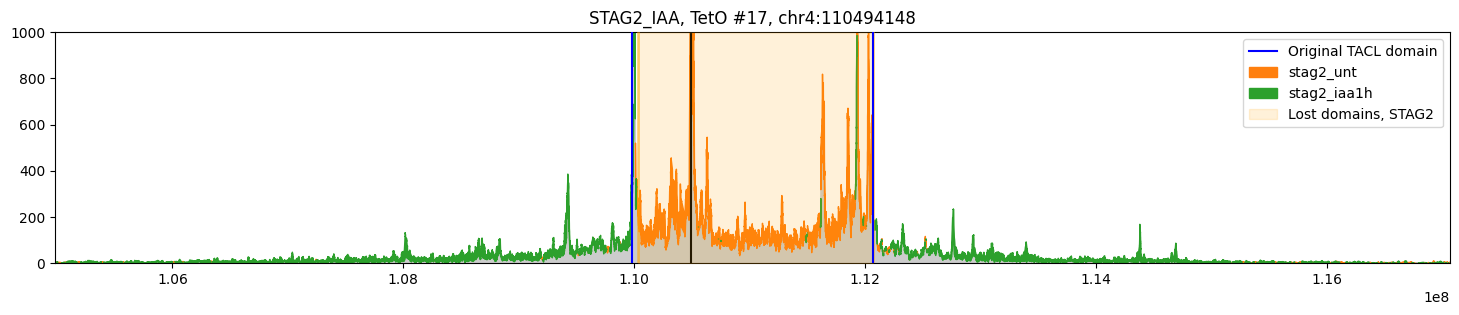

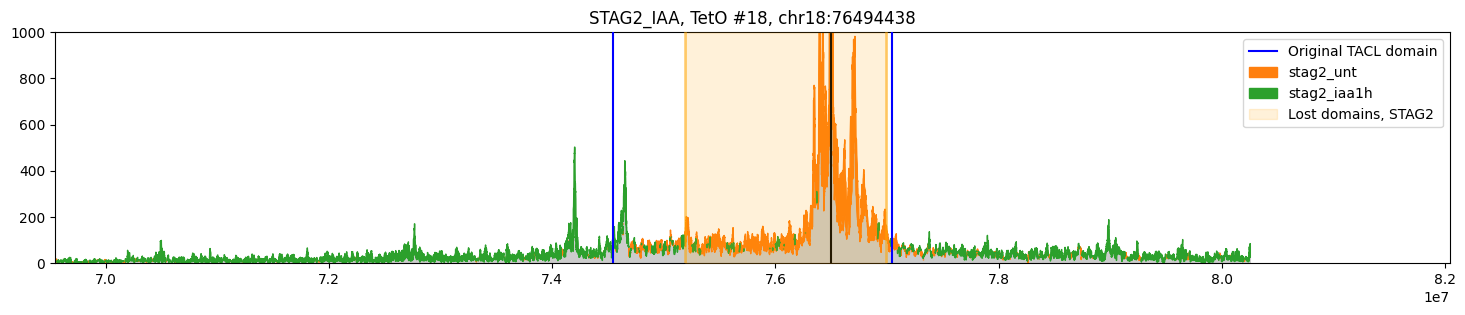

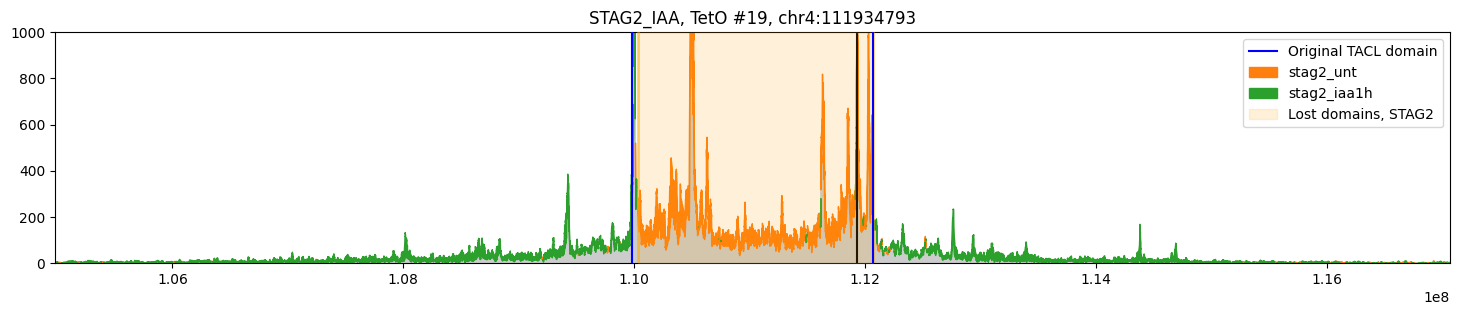

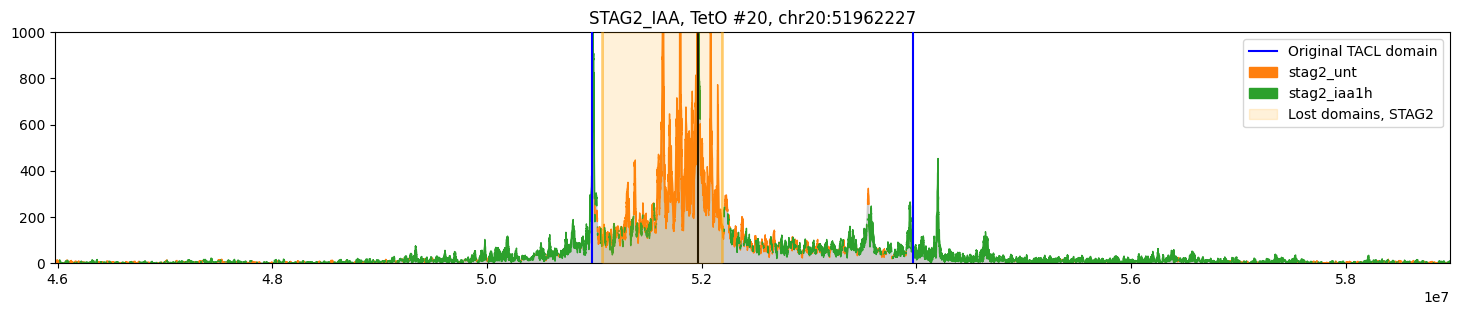

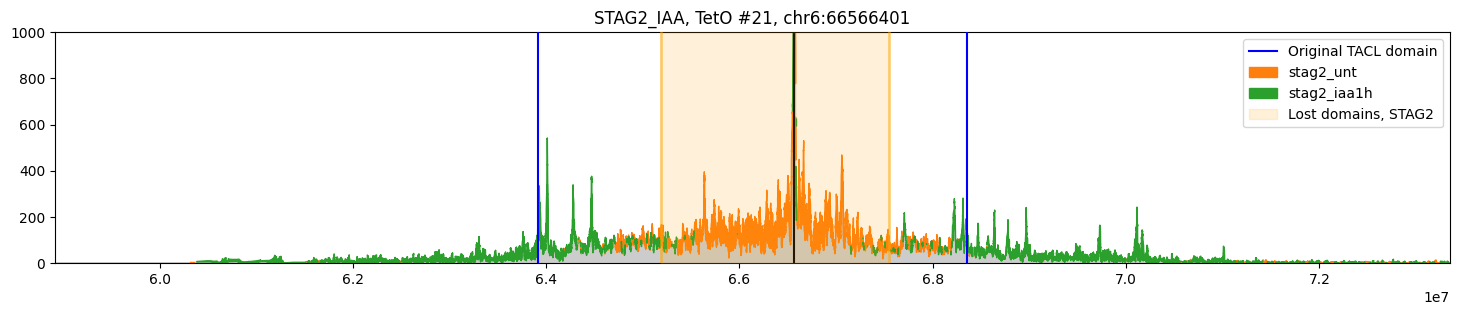

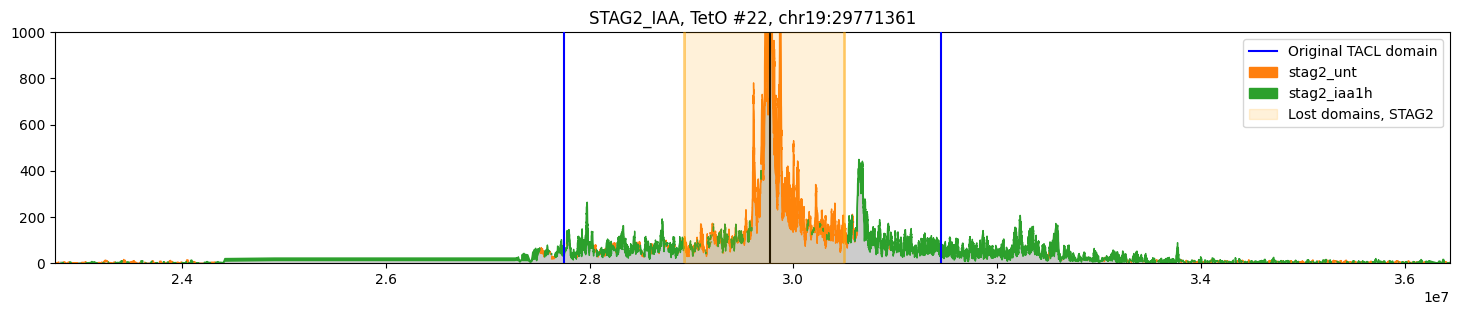

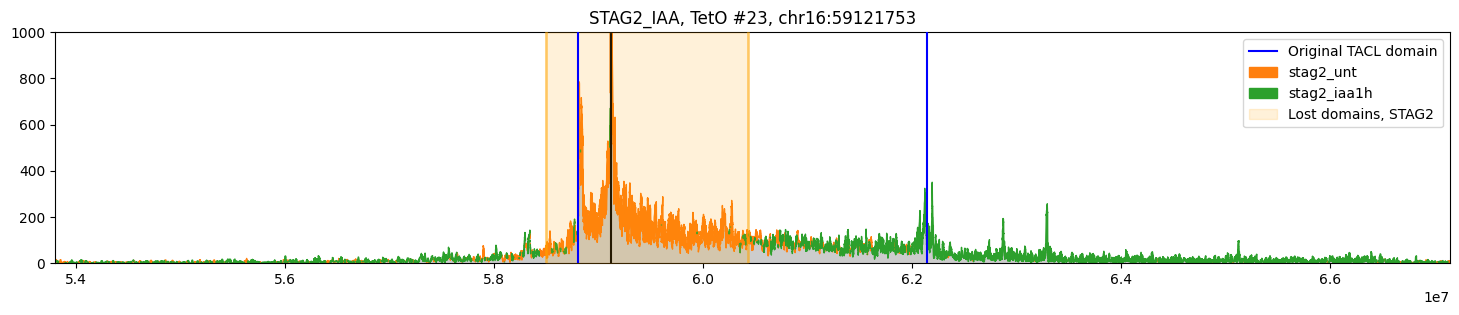

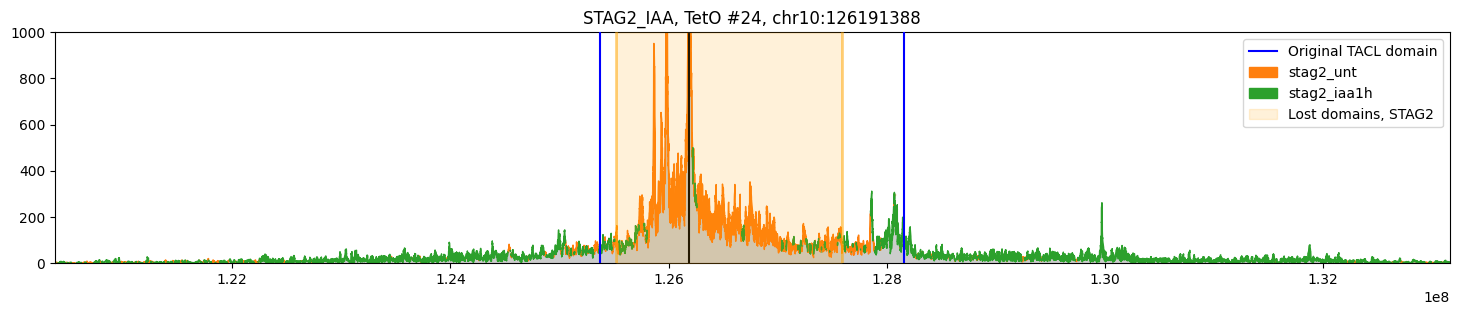

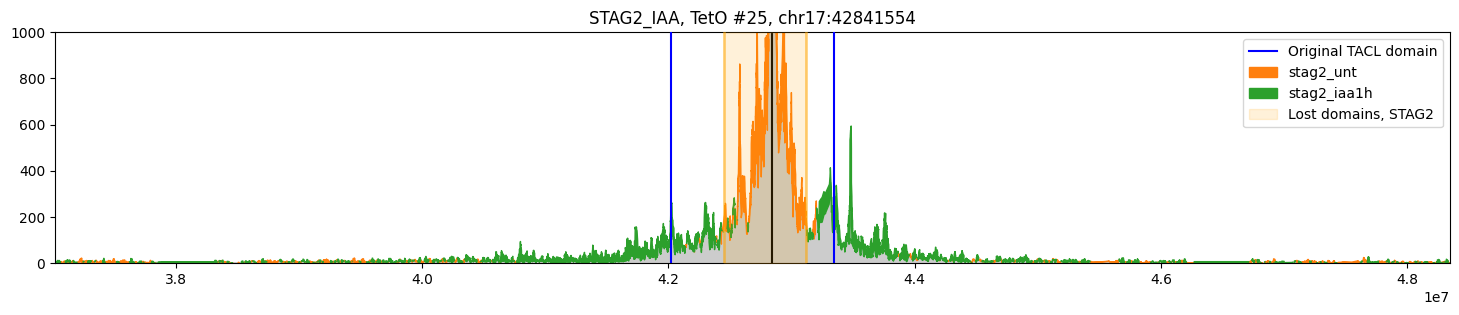

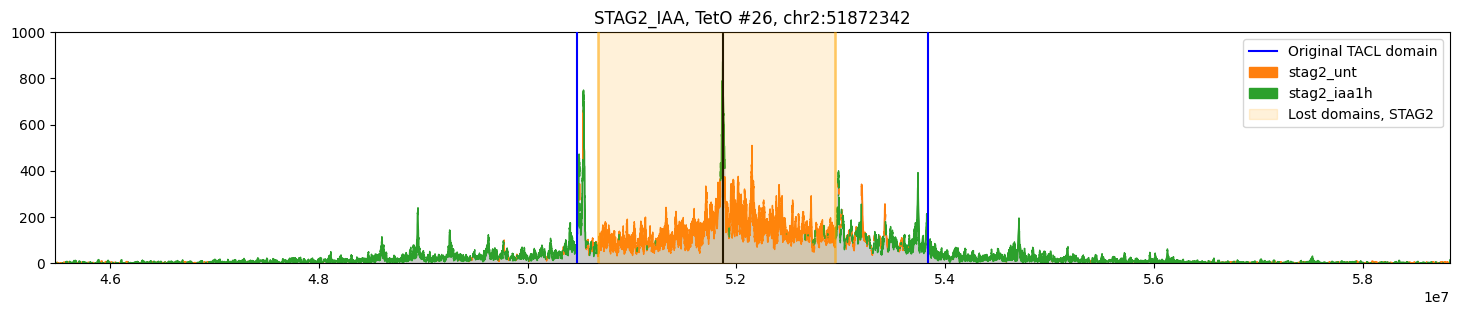

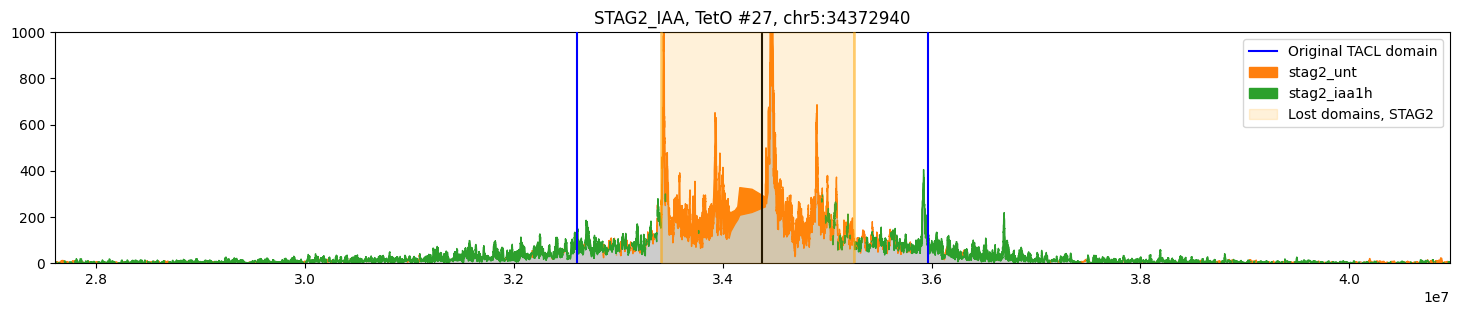

In [15]:
failed_viewpoints = []

for viewpoint_id_hmm in range(1, 28):
    if viewpoint_id_hmm not in failed_viewpoints:
        plot_tacl_domains(vp_data_merged, viewpoint_id_hmm, 'stag2_iaa', 'stag2_unt', 'stag2_iaa1h', 'stag2_dox3h', teto_coordinates, tacl_domains, 5000000)